# Initialize system

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

{'name': 'ScopeData0'}
{'name': 'ScopeData1'}
{'name': 'ScopeData2'}
{'name': 'ScopeData3'}
Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000300
UpTime       = 2:42:03
GitHash      = 0x9550c2a95f7e334393e52bfde914e26fb20f11b8
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 17 Jan 2024 11:42:17 PM PST
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading batcher configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_ASIC_u1_PLLBypass.yml
Loading /u1/lorenzor/epix-hr-m-320k/software/noteboo

In [5]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

In [6]:
#run some triggers and exercise lanes and locks
frames = 1000
rate = 1000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 1000
Stop Triggers command executed


In [7]:
#get locked lanes
root.getLaneLocks()

ASIC0: 0x45400c
ASIC1: 0x8be88
ASIC2: 0x200
ASIC3: 0xffffff


In [8]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0x20000
ASIC1: 0x5
ASIC2: 0x490000
ASIC3: 0x540140


In [9]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
root.Trigger()

In [10]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 0 frames
Checkpoint: DataReceiver 1 has 0 frames
Checkpoint: DataReceiver 2 has 0 frames
Checkpoint: DataReceiver 3 has 1 frames


# Here we select which ASIC we want to test

In [11]:
# Change these 3 lines when you want to select another ASIC
AsicNum = 1
dataDebug = DEBUG1
ASIC = ASIC1

# From here it's all the same
root.enableAllAsics(False)
root.enableAsic(AsicNum, True)
root.enableDataRcv(False)

dataDebug.enableDataDebug(True) ##### -- This was changed !!!
dataDebug.cleanData() ##### -- This was changed !!!

# Lorenzo - Helper functions

In [12]:
%run dataProcFunctions.ipynb     #this is were my function was stored

In [13]:
# helper functions
# clock speed is 168MHz. 1 tick is 0.006 us
def setSR0(width, delay) :
    REGCTRL.SR0Delay1.set(delay)
    REGCTRL.SR0Width1.set(width)
    print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
    print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
    
def setAcq1(width, delay) :
    REGCTRL.AcqDelay1.set(delay)
    REGCTRL.AcqWidth1.set(width)
    print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
    print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
    
def setAcq2(width, delay) :
    REGCTRL.AcqDelay2.set(delay)
    REGCTRL.AcqWidth2.set(width)
    print(f'Acq2 Width set to {REGCTRL.AcqWidth2_us.get():.3f}uS')
    print(f'Acq2 Delay set to {REGCTRL.AcqDelay2_us.get():.3f}uS')    

def setR0(width, delay) :
    REGCTRL.R0Delay.set(delay)
    REGCTRL.R0Width.set(width)
    print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
    print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 

    
def setSync(width, delay) :
    REGCTRL.SyncDelay.set(delay)
    REGCTRL.SyncWidth.set(width)
    print(f'Sync Delay set to {REGCTRL.SyncDelay_us.get():.3f}uS')     

In [14]:
# Steps = clock period of 168Mhz (5.95ns)
# Acq1 is 20us
# R0 after Acq1
# R0 Width set to 1.920uS
# SR0 needs to be launched after R0 delay + R0 width + alpha



# ------------------- 20 us integration time
AcqWidth = 3125
AcqDelay = 260
setAcq1(AcqWidth, AcqDelay)

R0Width = 3425
R0Delay = 100
setR0(R0Width, R0Delay)

SR0Width = 38000
SR0Delay = R0Width + R0Delay + 10
setSR0(SR0Width, SR0Delay)

# ------------------- 1 us integration time
AcqWidth = 160
AcqDelay = 260
setAcq1(AcqWidth, AcqDelay)

R0Width = 3425
R0Delay = 100
setR0(R0Width, R0Delay)

SR0Width = 38000
SR0Delay = R0Width + R0Delay + 10
setSR0(SR0Width, SR0Delay)

# Print human-readable values
print(f'-------------------------')
baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'Sampling done at: {REGCTRL.AcqWidth1_us.get()+REGCTRL.AcqDelay1_us.get()} uS')
print(f'-------------------------')

Acq1 Width set to 20.000uS
Acq1 Delay set to 1.664uS
R0 Width set to 21.920uS
R0 Delay set to 0.640uS
SR0 Width set to 226.190uS
SR0 Delay set to 21.042uS
Acq1 Width set to 1.024uS
Acq1 Delay set to 1.664uS
R0 Width set to 21.920uS
R0 Delay set to 0.640uS
SR0 Width set to 226.190uS
SR0 Delay set to 21.042uS
-------------------------
Baseline time:    1.024 uS
Integration time: 1.024 uS
Sampling done at: 2.6879999999999997 uS
-------------------------


# Set registers and variables

In [15]:
# Set some registers...
ASIC.mTest.set(False)
ASIC.CompTH_ePixM.set(30)
ASIC.Precharge_DAC_ePixM.set(45)
ASIC.DHg.set(False)

# Optimal bias settings
ASIC.RefinN.set(6)
ASIC.RefinP.set(2)

# ASIC3.pipoclk_delay_row0.set(15)
# ASIC3.pipoclk_delay_row1.set(15)
# ASIC3.pipoclk_delay_row2.set(15)
# ASIC3.pipoclk_delay_row3.set(15)

# Reference pixel
ref_row = 100
ref_col = 150

Data Descrambled
(192, 384, 1)
[45658]


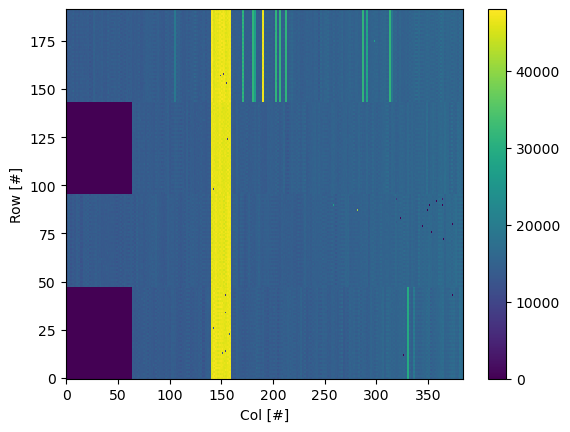

In [19]:
chargeInj=chargeInjection(firstCol=(ref_col-10),LastCol=(ref_col+10),PulserValue=1000, AsicNum=AsicNum)
data = readoutFrames(dataDebug, 1)
plt.imshow(data, interpolation='none', aspect='auto', origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.colorbar()

print(data[ref_row,ref_col])

In [ ]:
ChInjValues, pixelRamp = chargeInjRamp(dataDebug,AsicNum=AsicNum,Min=0, Max=1000, numSteps=20)

Data Descrambled
(192, 384, 1)
14858.0
Data Descrambled
(192, 384, 1)
15006.0
Data Descrambled
(192, 384, 1)
14895.0
Data Descrambled
(192, 384, 1)
14334.0
Data Descrambled
(192, 384, 1)
12802.0
Data Descrambled
(192, 384, 1)
9461.0


In [ ]:
# Fit gain
gain = np.polyfit(ChInjValues, pixelRamp, 1)[0]
print('Gain:{}'.format(gain))

plt.figure(figsize = (10,5))
plt.plot(ChInjValues, pixelRamp, marker='o')
plt.ylabel("Output [ADUs]")
plt.xlabel("Charge injection pulser value [#]")

In [ ]:
# stops the spamming of messages
numberOfTriggers = 100
data = readoutFrames(dataDebug, numberOfTriggers)

In [ ]:
# Plot raw data and histogram

dataTimeAvg = np.average(data,axis=2)

print(np.shape(dataTimeAvg))

plt.figure(figsize = (20,10))
plt.imshow(dataTimeAvg, interpolation='none', aspect='auto', origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title("Raw data - Avg: {:} - Reference pixel: {:}".format(getMedianDark(data),dataTimeAvg[ref_row,ref_col]))
plt.colorbar()


plt.figure(figsize = (10,5))
plt.hist(data[:,:,0].flatten(), range=[0,2**15],bins=2**8, log=True)
plt.title("Distribution of dark values")
plt.ylabel("Entries [#]")
plt.xlabel("ADC Value [ADUs]")

In [ ]:
# NOISE

# Uncomment to filter bad pixels!
# data, median_noise = filter_bad_pixels(data)

# Calculate data_noisemap
data_noisemap = np.std(data, axis=2)

# Flatten array
noisemap_flat = data_noisemap.flatten()

# Remove 0 noise (lanes not locked)
noisemap_flat = noisemap_flat[noisemap_flat > 0]

median_noise = np.median(noisemap_flat)
std_noise    = np.std(noisemap_flat)

# Get outliers (calculated as *2 noise)
noisemap_outliers = noisemap_flat[noisemap_flat > median_noise*2]




print('Noise: {:3f}'.format(median_noise))

plt.figure(figsize=(10,4))
plt.imshow(data_noisemap, interpolation='none', aspect='auto', vmin=0, vmax=median_noise*3, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title(r'Noise: {:.1f} $\pm$ {:.1f}'.format(median_noise, std_noise))
plt.colorbar()

fig, ax = plt.subplots(1,2, figsize=(13,3))

ax[0].hist(data_noisemap[(data_noisemap < 400) & (data_noisemap > 1)].flatten(),bins=2**8)
ax[0].set_title("Pixel noise distribution - Zoom on median")
ax[0].set_ylabel("Entries [#]")
ax[0].set_xlabel("Noise [ADUs]")

ax[1].hist(data_noisemap.flatten(),bins=2**8,log=True)
ax[0].set_title("Pixel noise distribution - Whole range")
ax[1].set_ylabel("Entries [#]")
ax[1].set_xlabel("Noise [ADUs]")



In [ ]:
# Subtract mean and display image
data_darksub = data - np.median(data, axis=2, keepdims=True)

plt.figure(figsize = (20,10))
plt.imshow(data_darksub[:,:,numberOfTriggers-1], interpolation='none', aspect='auto', vmin=-200, vmax=200, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.colorbar()

In [ ]:
# Disable data debug so it does not store data infinitely and crash software
dataDebug.cleanData()
print(dataDebug.getData().shape)
root.enableDataDebug(False)

In [ ]:
voltage = [1,10,20,30,40,50]
noiseVsV = [90.9,66.5,60.3,57.3,55.3,53.1]

plt.plot(voltage,noiseVsV, '-x')
plt.title('Noise vs Reverse bias')
plt.ylabel('Raw Noise [ADU]')
plt.xlabel('Reverse Bias [-V]')